<a href="https://colab.research.google.com/github/87tana/Image-Segmentation/blob/main/Tumor_Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)


Mounted at /content/drive/


In [2]:
cd '/content/drive/MyDrive/Project_Experiments/Tumor_Semantic_Segmentation/'

/content/drive/MyDrive/Project_Experiments/Tumor_Semantic_Segmentation


In [3]:
ls 'Tumor_Segmentation/train/_annotations.coco.json'


Tumor_Segmentation/train/_annotations.coco.json


In [4]:
## install pycocotools
!pip install pycocotools

In [5]:
from pycocotools.coco import COCO

In [6]:
## Download and import require libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from PIL import Image

import json

%matplotlib inline

In [7]:
# Replace the path with your actual path to the COCO annotations file
annotations_path = 'Tumor_Segmentation/train/_annotations.coco.json'

# Replace the path with your actual path to the directory containing COCO images
img_dir = 'Tumor_Segmentation/train'

# Initialize COCO object with the annotations file
coco = COCO(annotations_path)  #use the COCO API to load annotations


loading annotations into memory...
Done (t=0.84s)
creating index...
index created!


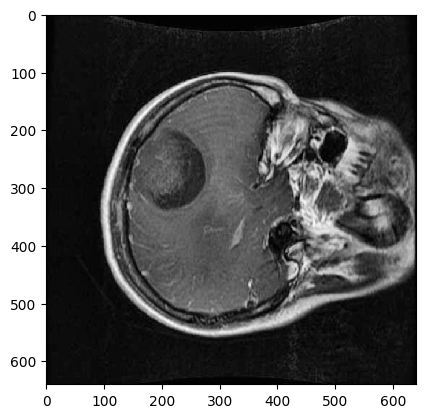

In [9]:
image = np.array(Image.open(os.path.join(img_dir, img['file_name'])))
plt.imshow(image, interpolation='nearest')
plt.show()

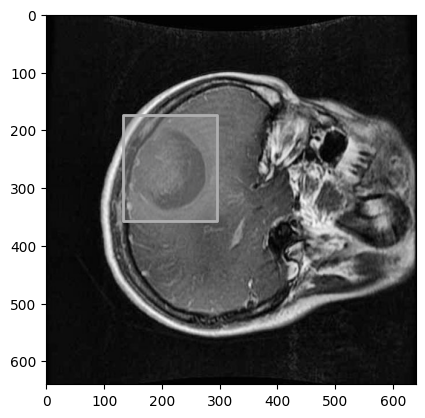

In [10]:
plt.imshow(image)
cat_ids = coco.getCatIds()
anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
anns = coco.loadAnns(anns_ids)
coco.showAnns(anns)

In [ ]:
anns[0]['segmentation']

[[295, 172.5, 132.5, 172.5, 132.5, 357.5, 295, 357.5, 295, 172.5]]

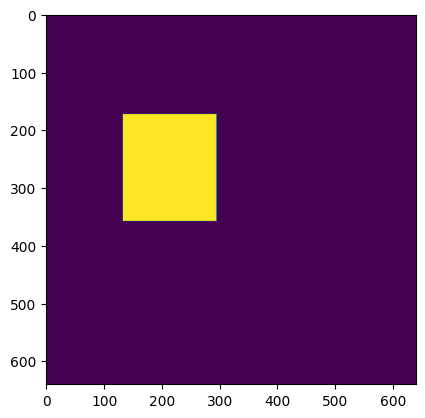

In [ ]:
mask = coco.annToMask(anns[0])
for i in range(len(anns)):
    mask += coco.annToMask(anns[i])

plt.imshow(mask)

In [12]:
annotations_path = 'Tumor_Segmentation/train/_annotations.coco.json'

with open(annotations_path,'r') as file:
    data = json.load(file)

for img in data['images'][:5]:
    print(img['file_name'])

2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg
2871_jpg.rf.3b6eadfbb369abc2b3bcb52b406b74f2.jpg
2921_jpg.rf.3b952f91f27a6248091e7601c22323ad.jpg
2777_jpg.rf.3b60ea7f7e70552e70e41528052018bd.jpg
2860_jpg.rf.3bb87fa4f938af5abfb1e17676ec1dad.jpg


In [13]:


data['categories']



[{'id': 0, 'name': 'Tumor', 'supercategory': 'none'},
 {'id': 1, 'name': '0', 'supercategory': 'Tumor'},
 {'id': 2, 'name': '1', 'supercategory': 'Tumor'}]

In [14]:
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

In [15]:
def draw_mask(img_names,data):
    fig,ax = plt.subplots(2,2,figsize =(15,15))

    for i,img_name in enumerate(img_names):
        img = cv2.imread(img_name)
        img_filename = os.path.basename(img_name)
        img_id = [item for item in data['images'] if item['file_name'] == img_filename][0]['id']
        img_mask = [mask for mask in data['annotations'] if mask['image_id']==img_id]
        point_list = img_mask[0]['segmentation']
        points = np.array(point_list,np.int32)

        points = points.reshape((-1,1,2))


        cv2.polylines(img,[points],True,(0,0,255),3)

        ax[i//2, i%2].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax[i//2, i%2].axis('off')
    plt.show()

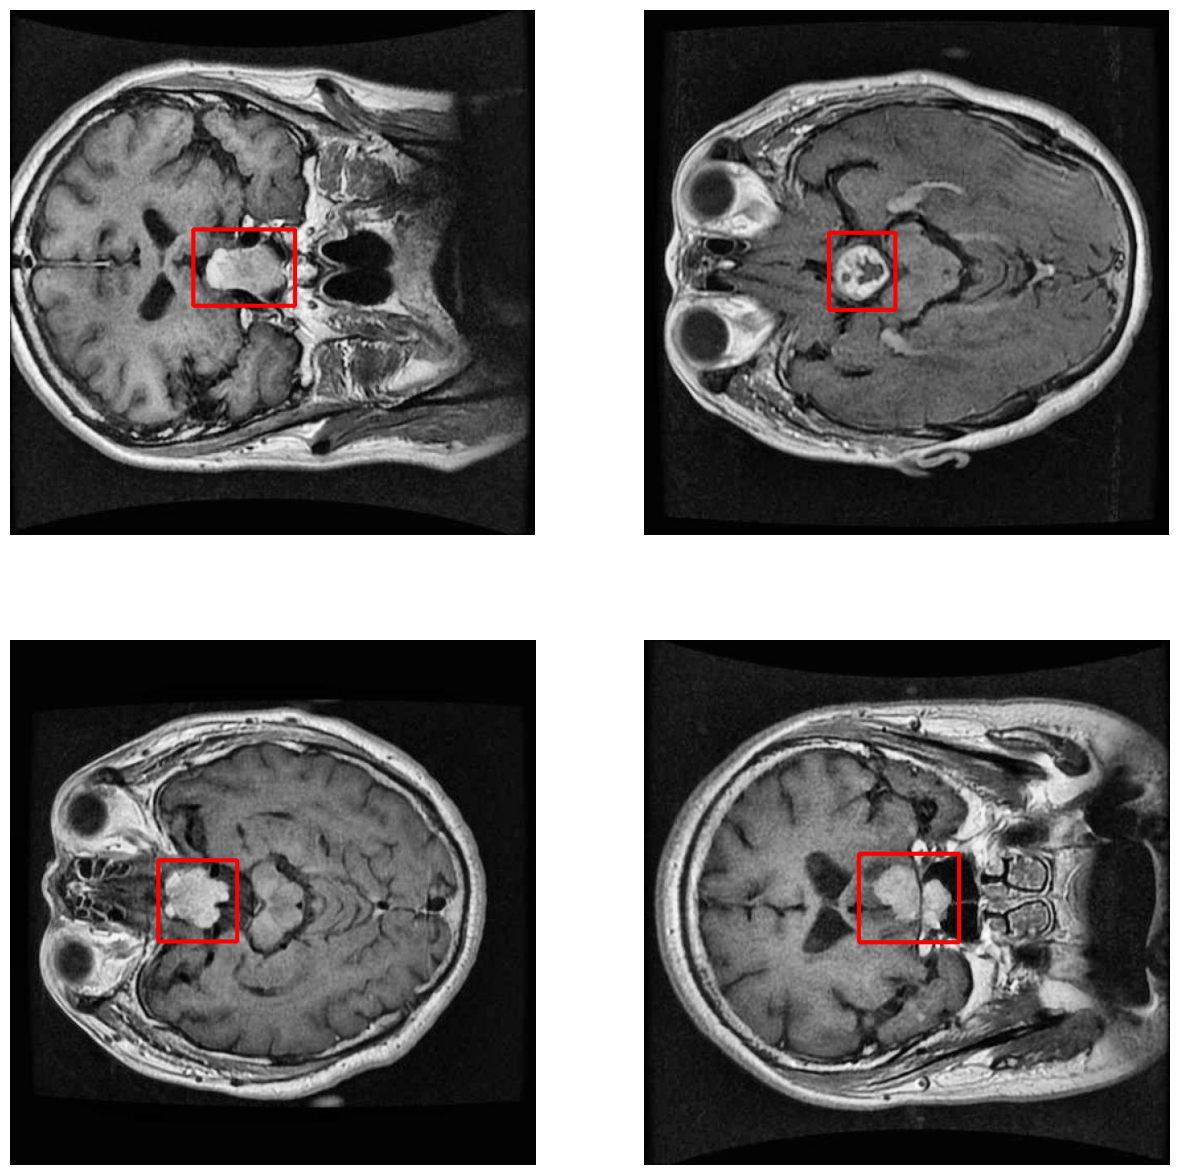

In [20]:
with open(annotations_path,'r') as file:
    data = json.load(file)

img_dir = 'Tumor_Segmentation/train'

all_img_files = [os.path.join(img_dir,img['file_name']) for img in data['images']]
random_file = random.sample(all_img_files,4)
draw_mask(random_file,data)

# Convert to mask

In [21]:
import json
import numpy as np
import skimage.draw
import tifffile
import os
import shutil
import matplotlib.pyplot as plt

def create_mask(image_info,annotations,output_folder,max_print=3):
    mask_np =np.zeros((image_info['height'],image_info['width']),dtype=np.uint8)
    obj_number =1
    printed_masks =0;

    for ann in annotations:
        if image_info['id'] == ann['image_id']:
            for seg_idx ,seg in enumerate(ann['segmentation']):
                rr, cc = skimage.draw.polygon(seg[1::2], seg[0::2], mask_np.shape)
                seg_mask = np.zeros_like(mask_np,dtype=np.uint8)
                seg_mask[rr,cc]=255
                mask_path = os.path.join(output_folder, f"{image_info['file_name'].replace('.jpg', '')}_seg_{seg_idx}.tif")
                tifffile.imwrite(mask_path, seg_mask)
                printed_masks += 1
                if printed_masks >= max_print:
                    return  # Exit the function if maximum number of masks to print is reached



In [27]:
def main(json_file,mask_output_folder,original_image_dir):
    with open(json_file, 'r') as f:
        data = json.load(f)

    images = data['images']
    annotations = data['annotations']
     # Ensure the output directories exist
    if not os.path.exists(mask_output_folder):
        os.makedirs(mask_output_folder)
    #if not os.path.exists(image_output_folder):
       # os.makedirs(image_output_folder)
    for img in images:
        # Create the masks
        create_mask(img, annotations, mask_output_folder)
        # Copy original images to the specified folder
        #original_image_path = os.path.join(original_image_dir, img['file_name'])
        #new_image_path = os.path.join(image_output_folder, os.path.basename(original_image_path))

        ## learn how to op
        #shutil.copy2(original_image_path, new_image_path)

In [30]:
original_image_dir = 'Tumor_Segmentation/test'  # Where your original images are stored
json_file = 'Tumor_Segmentation/test/_annotations.coco.json'
mask_output_folder = 'Tumor_Segmentation/test/masks'  # Modify this as needed. Using val2 so my data is not overwritten
main(json_file, mask_output_folder,original_image_dir)

original_image_dir = 'Tumor_Segmentation/train'  # Where your original images are stored
json_file = 'Tumor_Segmentation/train/_annotations.coco.json'
mask_output_folder = 'Tumor_Segmentation/train/masks'  # Modify this as needed. Using val2 so my data is not overwritten
main(json_file, mask_output_folder,original_image_dir)

original_image_dir = 'Tumor_Segmentation/valid'   # Where your original images are stored
json_file = 'Tumor_Segmentation/valid/_annotations.coco.json'
mask_output_folder = 'Tumor_Segmentation/valid/masks'  # Modify this as needed. Using val2 so my data is not overwritten
main(json_file, mask_output_folder, original_image_dir)

#Delete the image without the mask